# Training Gaussian Processes on Graph-Structured Inputs

**In this notebook, we will use Gauche to train Gaussian processes on molecular graphs.**

GPs are powerful probabilistic models that can be used for regression, uncertainty quantification and Bayesian optimisation tasks. However, general-purpose Gaussian process and Bayesian optimisation libraries typically assume that their inputs are matrices of fixed dimensionality. Yet, in many real-world applications the inputs we care about are not vectors, but can be more faithfully represented as graphs. For example, in molecular design, we often work with molecular graphs, where the nodes represent atoms and the edges represent bonds. In the following, we will show how we can use the graph GP utilities of Gauche to convert SMILES strings to molecular graphs and train a Gaussian process on them.

References:
- Gauche paper: [https://arxiv.org/abs/2212.04450](https://arxiv.org/abs/2212.04450)
- Gaussian Processes: [https://en.wikipedia.org/wiki/Gaussian_process](https://en.wikipedia.org/wiki/Gaussian_process)
- Graph-Structured Inputs: [https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics))

In [13]:
# If not already installed
!pip install graphein grakel

import warnings
from typing import List

warnings.filterwarnings("ignore") # Turn off Graphein warnings

import torch
import gpytorch
import numpy as np
from tqdm import tqdm
import graphein.molecule as gm
from matplotlib import pyplot as plt
from botorch import fit_gpytorch_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import GAUCHE dataloader and label rescaling utils
from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data

# Import GAUCHE utilities required for fitting GPs on graph-structured inputs 
from gauche import SIGP, NonTensorialInputs

# Import the Weisfeiler Lehman kernel
from gauche.kernels.graph_kernels import WeisfeilerLehmanKernel, VertexHistogramKernel

%matplotlib inline

  Using cached Cython-3.0.6-cp311-cp311-macosx_10_9_x86_64.whl.metadata (3.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 kB 1.3 MB/s eta 0:00:0000:0100:01
Using cached Cython-3.0.6-cp311-cp311-macosx_10_9_x86_64.whl (3.1 MB)
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492024 sha256=f35affc92203c9e6f75027e6bfe51f8d063e411584c0f35a003401514b49f0d7
  Stored in directory: /Users/ryan_rhys/Library/Caches/pip/wheels/da/19/ca/9d8c44cd311a955509d7e13da3f0bea42400c469ef825b580b
Successfully built future


## Defining the Graph GP Class

The most important component of Gauche's graph functionalities is the `SIGP` class, which allows us to use kernels over discrete inputs with GPyTorch and BoTorch machinery. This class is specifically designed for training Gaussian processes on graph-structured inputs, which need to be wrapped in a `NonTensorialInputs` object. In the following, we define a `GraphGP` by creating a `SIGP` subclass that accepts graph-structured inputs and a corresponding kernel.

Inside the `GraphGP` class, the mean function is set to `ConstantMean()` from GPyTorch, and the covariance function is set to the specified kernel function with the provided keyword arguments. The `forward` method of the `GraphGP` class takes an input `x` and returns a `MultivariateNormal` distribution representing the predictive posterior of the Gaussian process. It computes the mean and covariance of the predictive distribution using the mean and covariance functions defined earlier. To ensure numerical stability, a small jitter is added to the covariance matrix.


In [17]:
# Subclass the SIGP call that allows us to use kernels over
# discrete inputs with GPyTorch and BoTorch machinery


class GraphGP(SIGP):
    def __init__(
        self,
        train_x: NonTensorialInputs,
        train_y: torch.Tensor,
        likelihood: gpytorch.likelihoods.Likelihood,
        kernel: gpytorch.kernels.Kernel,
        **kernel_kwargs,
    ):
        """
        A subclass of the SIGP class that allows us to use kernels over
        discrete inputs with GPyTorch and BoTorch machinery.

        Parameters:
        -----------
        train_x: NonTensorialInputs
            The training inputs for the model. These are graph objects.
        train_y: torch.Tensor
            The training labels for the model.
        likelihood: gpytorch.likelihoods.Likelihood
            The likelihood function for the model.
        kernel: gpytorch.kernels.Kernel
            The kernel function for the model.
        **kernel_kwargs:
            The keyword arguments for the kernel function.
        """

        super().__init__(train_x, train_y, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        self.covariance = kernel(**kernel_kwargs)

    def forward(self, x):
        """
        A forward pass through the model.
        """
        mean = self.mean(torch.zeros(len(x), 1)).float()
        covariance = self.covariance(x)

        # because graph kernels operate over discrete inputs it is beneficial
        # to add some jitter for numerical stability
        jitter = max(covariance.diag().mean().detach().item() * 1e-4, 1e-4)
        covariance += torch.eye(len(x)) * jitter
        return gpytorch.distributions.MultivariateNormal(mean, covariance)

## Loading and Featurising the Data

In the following, we will use Gauche's built-in featurisation utilities to convert SMILES strings to molecular graphs. We will later use the `NonTensorialInputs` class to wrap the graphs in a `NonTensorialInputs` object, which can be used as input to the `GraphGP` class.

For convenience, we use the MolProp dataloader to read in the Photoswitch dataset. The dataloader uses the molecular graph featurisation utils from Graphein to support a wide range of different node and edge featurisation schemes that will be saved as labels of the resulting graph. 

References:
- Photoswitch dataset: Griffiths et al. [Data-driven discovery of molecular photoswitches with multioutput Gaussian processes](https://pubs.rsc.org/en/content/articlehtml/2022/sc/d2sc04306h). Chemical Science 2022.    
- Creating Molecular Graphs in Graphein: [https://graphein.ai/notebooks/molecule_tutorial.html](https://graphein.ai/notebooks/molecule_tutorial.html)

In [7]:
loader = MolPropLoader()
loader.load_benchmark("Photoswitch")

# Define the graphein featurisation config

graphein_config = gm.MoleculeGraphConfig(
    node_metadata_functions=[gm.total_degree],
    edge_metadata_functions=[gm.add_bond_type],
)

loader.featurize("molecular_graphs", graphein_config=graphein_config)

Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).


## Graph Kernel GP Regression on the Photoswitch Dataset ##

We define our experiment parameters. In this case we are reproducing the results of the E isomer transition wavelength prediction task from https://arxiv.org/abs/2008.03226 using 20 random splits in the ratio 80/20. Note that a validation set is not necessary for GP regression.

To enable an easy evaluation of different kernel functions and their hyperparameters on the Photoswitch dataset, we define the `evaluate_model` function takes in inputs `X` and labels `y`, as well as a kernel function and optionel kernel keyword arguments. It performs a random split of the data into training and test sets, trains a `GraphGP` model using the provided kernel, and evaluates the model's performance using various regression metrics such as R^2, RMSE, and MAE. Additionally, it computes a confidence-error curve plot to visualize the model's predictive uncertainty. 

In [15]:
# Set the expetimental parameters, including the number of random splits and split size

n_trials = 20
test_set_size = 0.2

# Define evaluation function that can be re-used with different kernels


def evaluate_model(
    X: List,
    y: np.array,
    kernel: gpytorch.kernels.Kernel,
    **kernel_kwargs: dict,
) -> (np.ndarray, np.ndarray):
    """
    A function that trains and evaluates a graph GP model with a
    given kernel and keyword arguments on a given dataset.
    It also plots the confidence-error curves for the model.

    Parameters:
    -----------
    X: List
        A list of Graphein graphs to train the GP on.
    y: np.ndarray
        The labels for the model.
    kernel: gpytorch.kernels.Kernel
        The kernel function for the model.
    **kernel_kwargs:
        The keyword arguments for the kernel function.

    Returns:
    --------
    r2_list: np.ndarray
        The R^2 scores for each trial.
    rmse_list: np.ndarray
        The RMSE scores for each trial.
    mae_list: np.ndarray
        The MAE scores for each trial.
    """

    # Initialise performance metric lists
    r2_list = []
    rmse_list = []
    mae_list = []

    # We pre-allocate array for plotting confidence-error curves
    n_test = int(len(y) * test_set_size) + 1
    mae_confidence_list = np.zeros((n_trials, n_test))

    progress_bar = tqdm(range(n_trials))

    for i in progress_bar:
        progress_bar.set_description(f"Running trial #{i}")

        # Carry out the random split with the current random seed
        # and standardise the outputs
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_set_size, random_state=i
        )
        _, y_train, _, y_test, y_scaler = transform_data(
            np.zeros_like(y_train), y_train, np.zeros_like(y_test), y_test
        )

        # Convert graph-structured inputs to custom data class for
        # non-tensorial inputs and convert labels to PyTorch tensors
        X_train = NonTensorialInputs(X_train)
        X_test = NonTensorialInputs(X_test)
        y_train = torch.tensor(y_train).flatten().float()
        y_test = torch.tensor(y_test).flatten().float()

        # Initialise GP likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = GraphGP(X_train, y_train, likelihood, kernel, **kernel_kwargs)

        # Define the marginal log likelihood used to optimise the model hyperparameters
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        # Use the BoTorch utility for fitting GPs in order
        # to use the LBFGS-B optimiser (recommended)
        fit_gpytorch_model(mll)

        # Get into evaluation (predictive posterior) mode and compute predictions
        model.eval()
        likelihood.eval()
        f_pred = model(X_test)
        y_pred = f_pred.mean
        y_var = f_pred.variance

        # Transform the predictions back to the original scale and calucalte eval metrics
        y_pred = y_scaler.inverse_transform(y_pred.detach().unsqueeze(dim=1))
        y_test = y_scaler.inverse_transform(y_test.detach().unsqueeze(dim=1))

        # Construct the MAE error for each level of confidence
        ranked_confidence_list = np.argsort(y_var.detach(), axis=0).flatten()
        for k in range(len(y_test)):
            conf = ranked_confidence_list[0 : k + 1]
            mae = mean_absolute_error(y_test[conf], y_pred[conf])
            mae_confidence_list[i, k] = mae

        # Compute R^2, RMSE and MAE on Test set
        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)

    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)

    # Print mean and standard error of the mean for each metric

    print(
        "\nmean R^2: {:.4f} +- {:.4f}".format(
            np.mean(r2_list), np.std(r2_list) / np.sqrt(len(r2_list))
        )
    )
    print(
        "mean RMSE: {:.4f} +- {:.4f}".format(
            np.mean(rmse_list), np.std(rmse_list) / np.sqrt(len(rmse_list))
        )
    )
    print(
        "mean MAE: {:.4f} +- {:.4f}\n".format(
            np.mean(mae_list), np.std(mae_list) / np.sqrt(len(mae_list))
        )
    )

    # Plot the mean-absolute error/confidence-error curves
    # with 1 sigma errorbars

    confidence_percentiles = np.arange(1e-14, 100, 100 / len(y_test))

    mae_mean = np.mean(mae_confidence_list, axis=0)
    mae_mean = np.flip(mae_mean)
    mae_std = np.std(mae_confidence_list, axis=0)
    mae_std = np.flip(mae_std)
    lower = mae_mean - mae_std
    upper = mae_mean + mae_std

    plt.plot(confidence_percentiles, mae_mean, label="mean")
    plt.fill_between(confidence_percentiles, lower, upper, alpha=0.2)
    plt.xlabel("Confidence Percentile")
    plt.ylabel("MAE (nm)")
    plt.ylim([0, np.max(upper) + 1])
    plt.xlim([0, 100 * ((len(y_test) - 1) / len(y_test))])
    plt.yticks(np.arange(0, np.max(upper) + 1, 5.0))
    plt.show()

    return r2_list, rmse_list, mae_list

## Selecting a Graph Kernel ##

Gauche provides a wide-range of kernels that can be used to quantify the similarity between graph-structured inputs and train Gaussian processes on them. These kernels are implemented in the `gauche.kernels.graph_kernels` module and can be used as drop-in replacements for any `gpytorch.kernels.Kernel`. These kernels mostly build on the GraKel library and currently include the:

- [RandomWalkKernel](https://ysig.github.io/GraKeL/0.1a8/kernels/random_walk.html) for unlabelled graphs.
- [ShortestPathKernel](https://ysig.github.io/GraKeL/0.1a8/kernels/shortest_path.html) for unlabelled graphs.
- [GraphletSamplingKernel](https://ysig.github.io/GraKeL/0.1a8/kernels/graphlet_sampling.html) for unlabelled graphs.
- [VertexHistogramKernel](https://ysig.github.io/GraKeL/0.1a8/kernels/vertex_histogram.html) for node-labelled graphs.
- [NeighborhoodHashKernel](https://ysig.github.io/GraKeL/0.1a8/kernels/neighborhood_hash.html): for node-labelled graphs.
- [RandomWalkLabeledKernel](https://ysig.github.io/GraKeL/0.1a8/kernels/random_walk.html): for node-labelled graphs.
- [ShortestPathLabeledKernel](https://ysig.github.io/GraKeL/0.1a8/kernels/shortest_path.html): for node-labelled graphs.
- [WeisfeilerLehmanKernel](https://ysig.github.io/GraKeL/0.1a8/kernels/weisfeiler_lehman.html) for node-labelled and optionally edge-labelled graphs.
- [EdgeHistogramKernel](https://ysig.github.io/GraKeL/0.1a8/kernels/edge_histogram.html): for edge-labelled graphs.

Any node and edge labels can be passed as a `node_label=...` or `edge_label=...` argument to the respective kernel function. These kernels already provide a powerful set of tools for quantifying the similarity between graphs and we plan to add additional kernels in the future.

In the following, we will be training a graph GP model with a Weisfeiler-Lehman kernel (using element types as node labels), and compare it to the performance of the much simpler vertex histogram kernel. 

Running trial #19: 100%|████████████████████████| 20/20 [00:10<00:00,  1.86it/s]


mean R^2: 0.8552 +- 0.0078
mean RMSE: 24.7722 +- 0.7579
mean MAE: 15.7634 +- 0.4203



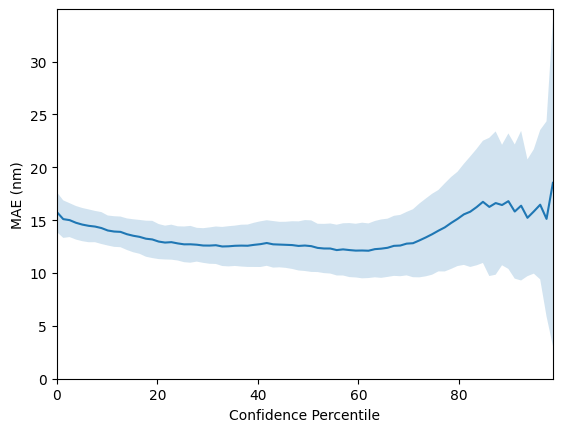

In [18]:
# Evaluate the performance of the Weisfeiler Lehman kernel using element types as node labels
_, _, _, = evaluate_model(
    loader.features, loader.labels, 
    WeisfeilerLehmanKernel, node_label="element",
)

Running trial #19: 100%|████████████████████████| 20/20 [00:11<00:00,  1.79it/s]


mean R^2: 0.4164 +- 0.0298
mean RMSE: 49.8792 +- 1.5456
mean MAE: 37.3413 +- 0.9067



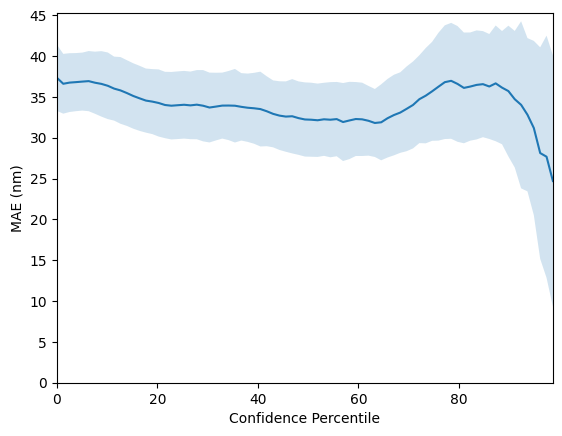

In [19]:
# Compare it to the performance of a simple vertex histogram kernel
_, _, _, = evaluate_model(
    loader.features, loader.labels, 
    VertexHistogramKernel, node_label="element",
)